In [87]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [2]:
dta = pd.read_csv('../data/master_scaled.csv', index_col=0)

In [3]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) if '/' in c else c for c in dta.columns]

In [4]:
dta.ccg.unique().shape

(71,)

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4


In [6]:
dta.shape

(1425, 12)

### Pairplot 

## Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1425, 13)

## Train test split 

In [9]:
train, test = train_test_split(dta,random_state=29)

## Capacity and utility model 

### Linear regression 

In [10]:
model = LinearRegression()

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))


#### Test performance 

In [11]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test)


(0.10602054842053182, 0.05644066658108282, 0.15769049950837277)

#### Train performance 

In [12]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.11079691012977885, 0.09849036002626932, 0.12351838797625048)

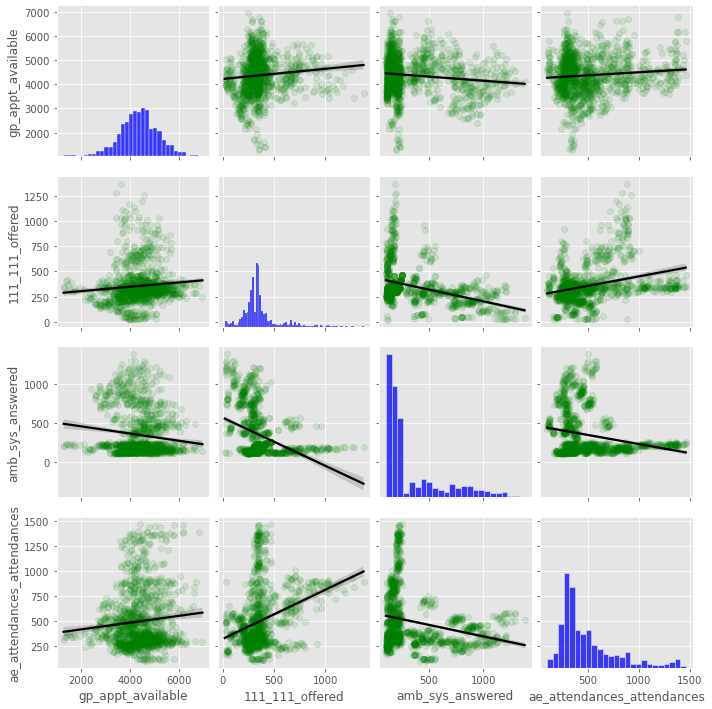

In [13]:
fig = sns.pairplot(dta[features + ['ae_attendances_attendances']].select_dtypes(include=np.number), kind="reg",
                  plot_kws={'line_kws':{'color':'black'}, 'scatter_kws': {'color':'green','alpha': 0.1}},
                  diag_kws={'color':'blue'})

plt.savefig('capacity_pair.png')

### Random forest 

In [14]:
model = RandomForestRegressor(max_depth=5, n_estimators=5, random_state=0)
#model = GradientBoostingRegressor(max_depth=5, n_estimators=5)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

    feats.append(model.feature_importances_)

#### Test performance 

In [15]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test), np.std(scores_test)


(0.4109352276771855,
 0.2880040999943283,
 0.4711145622474303,
 0.047039150403855916)

#### Train performance 

In [16]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.4780228636037042, 0.44379245045531335, 0.5106441872336565)

#### Feature importance 

In [17]:
for i,f in enumerate(features):
    
    imp = np.array(feats)[:,i]
    
    print(f'{f} importance: {np.mean(imp)} +/- {np.std(imp)}')

gp_appt_available importance: 0.14139057204437638 +/- 0.019711762837560036
111_111_offered importance: 0.3084423217091698 +/- 0.060754265705725424
amb_sys_answered importance: 0.5501671062464538 +/- 0.057959160910109234


### Gradient boosting 

In [18]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=5, random_state=1)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

#### Test performance 

In [19]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test)


(0.27411011142175185, 0.23725567812420778, 0.31060050341626444)

#### Train performance 

In [20]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.3056110856940129, 0.27986724300120114, 0.33601530056717754)

### Random Forest 

#### Vary max depth 

In [21]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, n_estimators=4, random_state=0)
    #model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

In [22]:
np.mean(res_train, axis=1)

array([0.15012806, 0.28171791, 0.35986281, 0.42167444, 0.47644278,
       0.51982399, 0.55680294])

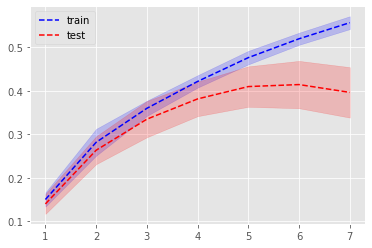

In [23]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)), color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)), color='r', alpha=0.2)

plt.legend(loc='best')

plt.show()

#### Vary n estimators 

In [24]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=5, n_estimators=est, random_state=0)
    #model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

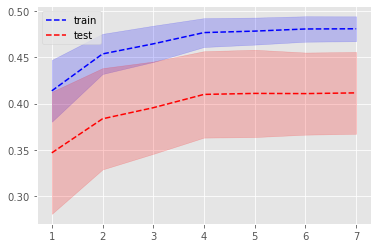

In [25]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)), color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)), color='r', alpha=0.2)

plt.legend(loc='best')

plt.show()

Random Forest performs better than linear regression -- keep random forest, max depth = 5, n_est=4

#### Fit with best params 

In [26]:
model = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)
#model = GradientBoostingRegressor(max_depth=5, n_estimators=5)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

    feats.append(model.feature_importances_)

#### Test performance 

In [27]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test), np.std(scores_test)


(0.4098582386994481,
 0.2957353642655597,
 0.47083141839628384,
 0.046542510472758196)

#### Train performance 

In [28]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.47644277720031636, 0.44522291677314796, 0.5051423037669189)

#### Feature importance 

In [29]:
for i,f in enumerate(features):
    
    imp = np.array(feats)[:,i]
    
    print(f'{f} importance: {np.mean(imp)} +/- {np.std(imp)}')

gp_appt_available importance: 0.1454292680738685 +/- 0.02268182709170066
111_111_offered importance: 0.2865200579477944 +/- 0.07447529004848617
amb_sys_answered importance: 0.5680506739783372 +/- 0.06636991384441417


## Population and health index model 

### Group data 

In [30]:
def group_data(data, features):

    features = ['population',
                'People', 'Places',
                'Lives']


    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

            #print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances'] = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

### Linear Regression 

In [31]:
model = LinearRegression()

features = ['population',
            'People', 'Places',
            'Lives']

grouped = group_data(dta, features)
    
y = grouped['ae_attendances_attendances']
X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))



/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

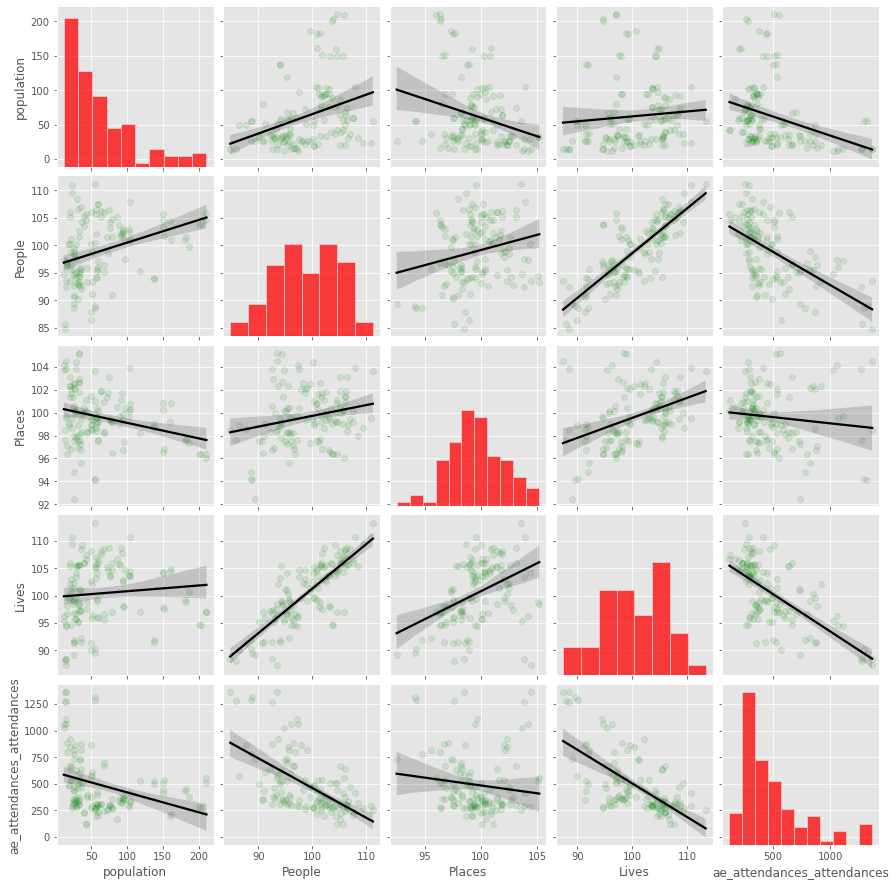

In [32]:
fig = sns.pairplot(grouped.select_dtypes(include=np.number), kind="reg",
                  plot_kws={'line_kws':{'color':'black'}, 'scatter_kws': {'color':'green','alpha': 0.1}},
                  diag_kws={'color':'red'})

plt.savefig('grouped_pair.png')

#### Test performance 

In [33]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test), np.std(scores_test)


(0.3808749053133749,
 -0.5373955587247319,
 0.6424324026081756,
 0.24295522603160757)

#### Train performance 

In [34]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.5183272588610892, 0.4384618539127745, 0.5934460570241109)

### Random Forest 

In [35]:
model = RandomForestRegressor(max_depth=4, n_estimators=2, random_state=0)
#model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))

#### Test performance 

In [36]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test), np.std(scores_test)


(0.5377820479819053,
 0.09000127558191784,
 0.7879776100597966,
 0.17070574458447024)

#### Train performance 

In [37]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.7992853191917355, 0.7377254598678011, 0.8371649229821974)

#### Vary max depth 

In [38]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, n_estimators=3, random_state=0)
    #model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

In [39]:
np.mean(res_train, axis=1)

array([0.49875515, 0.68527404, 0.77997625, 0.82013028, 0.85163995,
       0.8765158 , 0.89273103])

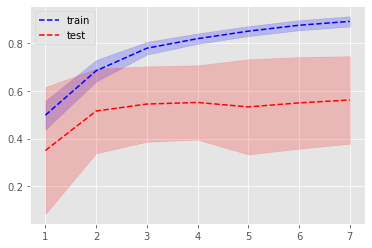

In [40]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)), color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)), color='r', alpha=0.2)

plt.legend(loc='best')

plt.show()

#### Vary n estimators 

In [41]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=3, n_estimators=est, random_state=0)
    #model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

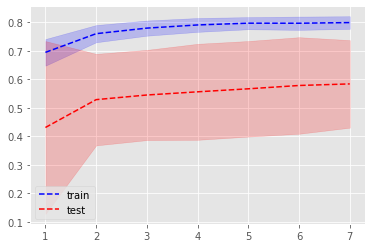

In [42]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)), color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)), color='r', alpha=0.2)

plt.legend(loc='best')

plt.show()

keep random forest, max_depth=3, n_est = 2

#### Fit with best estimator 

In [43]:
model = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)
#model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feat = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index], y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], y.iloc[train_index]))
    
    feat.append(model.feature_importances_)

#### Test performance 

In [44]:
np.mean(scores_test), np.min(scores_test), np.max(scores_test), np.std(scores_test)


(0.5290529673149807,
 0.09034167818396921,
 0.7705241011564301,
 0.16051871275485302)

#### Train performance 

In [45]:
np.mean(scores_train), np.min(scores_train), np.max(scores_train)

(0.7604513218040253, 0.6992760934095497, 0.8031014860645067)

#### Feature importance 

In [46]:
for i,f in enumerate(features):
    
    imp = np.array(feat)[:,i]
    
    print(f'{f} importance: {np.mean(imp)} +/- {np.std(imp)}')

population importance: 0.5605223690398808 +/- 0.13741038409188167
People importance: 0.10355133679190943 +/- 0.10481845572878817
Places importance: 0.07394232048588135 +/- 0.07023222136634558
Lives importance: 0.26198397368232823 +/- 0.17522344348554392


### Fit predict population health 

In [47]:
model = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)
#model = GradientBoostingRegressor(max_depth=3, n_estimators=3, random_state=0)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
results = pd.DataFrame()


scores_train, scores_test, feat = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    test = X.iloc[test_index].copy()
    test['ae_predicted'] = model.predict(X.iloc[test_index])
    
    results = results.append(test, ignore_index=True)

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/515991931.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/515991931.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/515991931.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(test, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/515991931.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [48]:
results

,population,People,Places,Lives,ae_predicted
0,13.9240,84.800000,98.500000,88.500000,1270.932902
1,14.8942,97.200000,99.700000,94.400000,1051.002273
2,26.5294,97.850000,102.100000,99.500000,472.715590
3,28.5372,95.200000,100.100000,96.600000,472.715590
4,29.1775,100.200000,104.400000,104.200000,381.722990
...,...,...,...,...,...
123,58.6485,94.200000,99.200000,99.000000,385.192306
124,63.3558,106.166667,101.866667,107.616667,332.828873
125,92.7598,101.800000,101.733333,107.750000,332.828873
126,102.1991,103.040000,99.660000,103.696667,385.192306


In [49]:
dta = dta.merge(results[['population','ae_predicted']], left_on='population', right_on='population')

In [50]:
dta

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,rand1,ae_predicted
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4,0.548814,1051.002273
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4,0.715189,1051.002273
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4,0.602763,1051.002273
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4,0.544883,1051.002273
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4,0.423655,1051.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,X2C4Y,Aug,281.008273,253.093792,459.652700,306.843650,3982.517935,390.405530,44.0337,93.3,98.3,97.6,0.049500,515.867172
1421,X2C4Y,Sep,263.936917,240.868701,453.078703,305.262399,4598.750502,388.679580,44.0337,93.3,98.3,97.6,0.101855,515.867172
1422,X2C4Y,Oct,286.454848,254.680032,488.348051,327.202669,5225.611293,391.268506,44.0337,93.3,98.3,97.6,0.134174,515.867172
1423,X2C4Y,Nov,326.984206,276.374619,499.497654,306.953594,4606.948769,389.542555,44.0337,93.3,98.3,97.6,0.316541,515.867172


## Combined model 

In [51]:
#capacity utility model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)

#combinator
final = LinearRegression()

train, test = train_test_split(dta,random_state=29)

#split training data into two sets
train_0, train_1 = train_test_split(train, train_size=0.75, random_state=29)

print(len(train_0))

#train models

#capacity utility
capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

pophealth_features = ['population',
                    'People', 'Places', 'Lives']

y_0 = train_0['ae_attendances_attendances']
X_0 = train_0[capacity_features]

rf1.fit(X_0,y_0)

#population health

grouped = group_data(train_0, pophealth_features)
    
y_0g = grouped['ae_attendances_attendances']
X_0g = grouped[pophealth_features]

print(len(X_0g))

rf2.fit(X_0g,y_0g)

#predict

y_pred_cu = rf1.predict(train_1[capacity_features])

print(rf1.score(train_1[capacity_features], train_1['ae_attendances_attendances']))

#y_pred_ph = rf2.predict(train_1[pophealth_features])
y_pred_ph = train_1['ae_predicted']

#print(rf2.score(train_1[pophealth_features], train_1['ae_attendances_attendances']))

801


/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

128
0.40477370122358636


/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

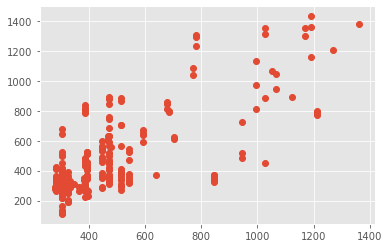

In [52]:
plt.plot(y_pred_ph, train_1['ae_attendances_attendances'], 'o')

In [53]:
X_f = np.vstack([y_pred_cu, y_pred_ph]).T
y_f = train_1['ae_attendances_attendances']

final.fit(X_f,y_f)

final.score(X_f,y_f)

0.6223340990025038

## Check performance on held out data 

In [54]:
from sklearn.metrics import r2_score as r2

y_pred_cu = rf1.predict(test[capacity_features])

print(rf1.score(test[capacity_features], test['ae_attendances_attendances']))

#y_pred_ph = rf2.predict(test[pophealth_features])

y_pred_ph = test['ae_predicted']

print(r2(test['ae_attendances_attendances'], test['ae_predicted']))

y_pred_final = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

#print(r2_score(test['ae_attendances_attendances'], y_pred_final))

print(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,test['ae_attendances_attendances']))

0.441254188439128
0.5452611564926692
0.6355467401718082


In [55]:
final.coef_

array([0.5192824 , 0.62027602])

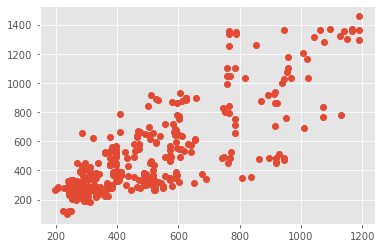

In [56]:
plt.plot(y_pred_final, test['ae_attendances_attendances'], 'o')

## Cross validate whole model 

In [57]:
def cv_combined(dta):
    
    # splitter for cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_final, scores_rf1, scores_rf2, coefs_final = [],[],[],[]
    
    k=1
    
    for train_index, test_index in cv.split(dta):
        
        print(f'\n Split {k} \n')
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]
        
        #capacity utility model
        rf1 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

        #population health model
        rf2 = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)

        #combinator
        final = LinearRegression()

        #split training data into two sets
        train_0, train_1 = train_test_split(train, train_size=7/8, random_state=29)

        #train models

        #capacity utility
        capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

        pophealth_features = ['population',
                            'People', 'Places', 'Lives']

        y_0 = train_0['ae_attendances_attendances']
        X_0 = train_0[capacity_features]

        rf1.fit(X_0,y_0)

        #population health

        #grouped = group_data(train_0, pophealth_features)

        #y_0g = grouped['ae_attendances_attendances']
        #X_0g = grouped[pophealth_features]

        #rf2.fit(X_0g,y_0g)
    

        #predict

        y_pred_cu = rf1.predict(train_1[capacity_features])

        print('Capacity training score:',
              rf1.score(train_1[capacity_features], train_1['ae_attendances_attendances']))

        #y_pred_ph = rf2.predict(train_1[pophealth_features])
        y_pred_ph = train_1['ae_predicted']
        
        #print('Population health training score:',
        #      rf2.score(train_1[pophealth_features], train_1['ae_attendances_attendances']))

        
        #final
        
        X_f = np.vstack([y_pred_cu, y_pred_ph]).T
        y_f = train_1['ae_attendances_attendances']

        final.fit(X_f,y_f)

        print('Combined training score:',final.score(X_f,y_f))
        
        
        #predict on test data
        
        
        y_pred_cu = rf1.predict(test[capacity_features])

        scores_rf1.append(rf1.score(test[capacity_features], test['ae_attendances_attendances']))

        #y_pred_ph = rf2.predict(test[pophealth_features])
        
        y_pred_ph = test['ae_predicted']

        scores_rf2.append(r2(test['ae_attendances_attendances'],test['ae_predicted']))

        y_pred_final = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)


        scores_final.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,test['ae_attendances_attendances']))
        
        coefs_final.append(final.coef_)
        
        k+=1
        
    return scores_final, scores_rf1, scores_rf2, coefs_final

In [58]:
scores_final, scores_rf1, scores_rf2, coefs = cv_combined(dta)


 Split 1 

Capacity training score: 0.4141608131323061
Combined training score: 0.7549395493552277

 Split 2 

Capacity training score: 0.3420394248893034
Combined training score: 0.6385179287264033

 Split 3 

Capacity training score: 0.4006967699584254
Combined training score: 0.741375277342837

 Split 4 

Capacity training score: 0.3813810108449417
Combined training score: 0.6842809525515927

 Split 5 

Capacity training score: 0.41017379481928506
Combined training score: 0.7153547445314681

 Split 6 

Capacity training score: 0.42592796314779824
Combined training score: 0.7247843951083

 Split 7 

Capacity training score: 0.35302345358509246
Combined training score: 0.6380542747508988

 Split 8 

Capacity training score: 0.38357484936396635
Combined training score: 0.7192606418122236

 Split 9 

Capacity training score: 0.377626037722392
Combined training score: 0.6535882971694371

 Split 10 

Capacity training score: 0.3400278007184029
Combined training score: 0.6901343147891787


### Results for paper 

In [59]:
np.mean(scores_final), np.std(scores_final)

(0.6528974443543204, 0.041710758485702985)

In [60]:
np.mean(scores_rf1), np.std(scores_rf1)

(0.3978727026725051, 0.05023625345135597)

In [61]:
np.mean(scores_rf2), np.std(scores_rf2)

(0.5815118425124604, 0.0497675012215943)

In [62]:
np.mean(coefs, axis=0), np.std(coefs, axis=0)

(array([0.50342099, 0.69577325]), array([0.09503895, 0.05785739]))

## Combined model with optimised parameters 

In [63]:
#capacity utility model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=3, n_estimators=2, random_state=0)

In [64]:
dta.shape

(1425, 14)

In [65]:
def fit_ph(dta, features, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']], left_on='population', right_on='population')
        
    return dta

In [66]:
def fit_capacity(dta, features, model):
    
    y = dta['ae_attendances_attendances']
    X = dta[features]

    model.fit(X,y)
    
    return model

In [67]:
def fit_combined(train, rf1, m1_features, train_size=7/8):
    
    final = LinearRegression()

    #split training data into two sets
    train_0, train_1 = train_test_split(train, train_size=train_size, random_state=29)

    #train capactiy model
    
    rf1 = fit_capacity(train_0, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(train_1[m1_features])

    print('Capacity training score:',
              rf1.score(train_1[m1_features], train_1['ae_attendances_attendances']))

    
    #use pre-predicted average attendances
    
    y_pred_2 = train_1['ae_predicted']
        
    print('Population health training score:',
              r2(train_1['ae_attendances_attendances'], train_1['ae_predicted']))

        
    #final
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = train_1['ae_attendances_attendances']

    final.fit(X_f,y_f)

    print('Combined training score:',final.score(X_f,y_f))
    
    return rf1,final        

In [68]:
def cv_combined(dta, rf1, rf2):
    
    # splitter for cross validation 
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_final, scores_rf1, scores_rf2 = [],[],[]
    
    k=1
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    dta_pred = pd.DataFrame()
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    print(dta.shape)
    
    for train_index, test_index in cv.split(dta):
        
        print(f'\n Split {k} \n')
        
        #dta_run = fit_ph(dta, pophealth_features, rf2)
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]

        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)
        
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        scores_rf1.append(rf1.score(test[capacity_features], test['ae_attendances_attendances']))

        #y_pred_ph = rf2.predict(test[pophealth_features])
        y_pred_ph = test['ae_predicted']

        scores_rf2.append(r2(test['ae_attendances_attendances'],test['ae_predicted']))
        
        preds = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

        scores_final.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,test['ae_attendances_attendances']))
        
        test_pred = test.copy()
        test_pred['predicted'] = preds
        test_pred['true'] = test['ae_attendances_attendances'].values
        
        test_pred['iter'] = [k for i in test_pred.index]
        
        dta_pred = dta_pred.append(test_pred, ignore_index=False)
        
        
        k+=1
        
    return scores_final, scores_rf1, scores_rf2, dta_pred

In [69]:
scores_final, scores_rf1, scores_rf2, dta_pred = cv_combined(dta, rf1, rf2)

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14)

 Split 1 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277

 Split 2 

Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033

 Split 3 

Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837

 Split 4 

Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927

 Split 5 

Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681

 Split 6 

Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083

 Split 7 

Capacity training score: 0.35302345358509246
Population healt

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a


 Split 9 

Capacity training score: 0.377626037722392
Population health training score: 0.5837256176239017
Combined training score: 0.6535882971694371

 Split 10 

Capacity training score: 0.3400278007184029
Population health training score: 0.6262156777052417
Combined training score: 0.6901343147891787

 Split 11 

Capacity training score: 0.3924071738253754
Population health training score: 0.5747949676678721
Combined training score: 0.6517321433552652

 Split 12 

Capacity training score: 0.35755536890430184
Population health training score: 0.5278559474377899
Combined training score: 0.6522021456159804

 Split 13 

Capacity training score: 0.30323943796673203
Population health training score: 0.5103561342832537
Combined training score: 0.61551732384301

 Split 14 

Capacity training score: 0.4238722158783106
Population health training score: 0.49575368006311216
Combined training score: 0.6434850969160426

 Split 15 

Capacity training score: 0.28760215242908205
Population health t

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a


 Split 24 

Capacity training score: 0.42416264953227634
Population health training score: 0.5077652592580675
Combined training score: 0.6541915313221873

 Split 25 

Capacity training score: 0.3688279393903472
Population health training score: 0.6475006774335101
Combined training score: 0.715394576590846


/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3230082567.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dta_pred = dta_pred.append(test_pred, ignore_index=False)


In [70]:
np.mean(scores_final), np.std(scores_final)

(0.6528974443543204, 0.041710758485702985)

In [71]:
np.mean(scores_rf1), np.std(scores_rf1)

(0.3978727026725051, 0.05023625345135597)

In [72]:
np.mean(scores_rf2), np.std(scores_rf2)

(0.5815118425124604, 0.0497675012215943)

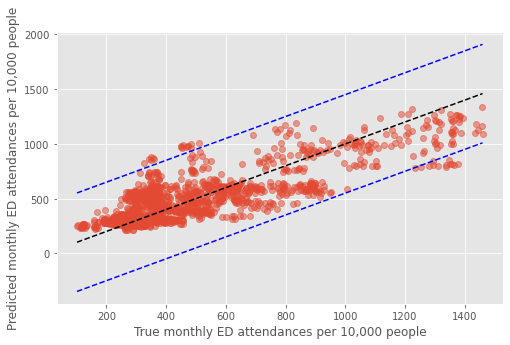

In [73]:
fig,ax = plt.subplots(figsize=(8,5))

mean_pred, true = [],[]

for i in dta_pred.index.unique():
    
    mean_pred.append(dta_pred.loc[i]['predicted'].mean())
    true.append(dta_pred.loc[i]['true'].mean())

plt.plot(true, mean_pred, 'o', alpha=0.5)

xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
plt.plot(xx,xx,'k--')
plt.plot(xx, xx-450, 'b--')
plt.plot(xx, xx+450, 'b--')

plt.xlabel('True monthly ED attendances per 10,000 people')
plt.ylabel('Predicted monthly ED attendances per 10,000 people')
plt.savefig('true_predicted_combined.png')
plt.show()

In [74]:
dta_pred.loc[abs(dta_pred.predicted - dta_pred.true)>450].sort_values(by=['ccg','month'])[['ccg','month']].drop_duplicates()

,ccg,month
675,00T,Nov
692,01G,Apr
690,01G,Feb
689,01G,Jan
694,01G,Jun
691,01G,Mar
693,01G,May
698,01G,Oct
722,01K,Oct
181,03H,Feb


14L = Manchester

99A = Liverpool

01G = Saltford

99C = North Tyneside

10R = Portsmouth

03F = Hull

## Permutation Feature Importance 

In [75]:
def fit_ph_shuffle(dta, features,f, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]
    
    X_shuffled = X.copy()
    
    X_shuffled[f] = np.random.permutation(X[f].values)
    
    
    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X_shuffled.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']], left_on='population', right_on='population')
        
    return dta

In [76]:
def permeate_feature(dta, f,rf1, rf2):
    
    
    shuffled = dta.copy()

    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
#            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    if f in capacity_features:
    
        shuffled[f] = np.random.permutation(dta[f].values)
    
    else:
        
        shuffled = fit_ph_shuffle(shuffled, pophealth_features,f, rf2)
        
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    print(shuffled.shape, dta.shape)
    # splitter for cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    #importances = pd.DataFrame()
    
    shuffled_score, true_score  = [],[]
    
    print(f'running for {f} \n')
    
    for train_index, test_index in cv.split(dta):
        
        test_shuffled = shuffled.iloc[test_index]
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]
        
        
        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)

        
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        y_pred_ph = test['ae_predicted']
        
        y_pred_cus = rf1.predict(test_shuffled[capacity_features])
        
        if f in capacity_features:

            y_pred_phs = test['ae_predicted']
            
        else:
            
            y_pred_phs = test_shuffled['ae_predicted']
            
        
        true_score.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,\
                                                test['ae_attendances_attendances']))
        
        shuffled_score.append(true_score[-1] - final.score(np.vstack([y_pred_cus, y_pred_phs]).T,\
                                            test['ae_attendances_attendances']))
        
    print(f'{f} complete\n')
    
    return true_score, shuffled_score       

In [77]:
def feature_importance_combined(dta, rf1, rf2):
    
    importances = pd.DataFrame()
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    #            '111_111_answered', 'amb_sys_made']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    
    for f in capacity_features + pophealth_features:
        
        
        true_score, shuffled_score = permeate_feature(dta, f,rf1, rf2)
        
        if 'score' in importances.columns:
        
            importances['score'] = np.mean([importances['score'].values, true_score],axis=0)
            
        else:
            
            importances['score'] = true_score
            
        importances[f] = shuffled_score
  

    return importances

In [78]:
importances = feature_importance_combined(dta, rf1, rf2)

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for gp_appt_available 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Comb

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/3766363438.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for 111_111_offered 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combin

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for amb_sys_answered 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combi

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for population 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combined tr

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for People 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combined traini

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for Places 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combined traini

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

(1425, 14) (1425, 14)
running for Lives 

Capacity training score: 0.4141608131323061
Population health training score: 0.7130266312198239
Combined training score: 0.7549395493552277
Capacity training score: 0.3420394248893034
Population health training score: 0.5250696053272552
Combined training score: 0.6385179287264033
Capacity training score: 0.4006967699584254
Population health training score: 0.6821568531188111
Combined training score: 0.741375277342837
Capacity training score: 0.3813810108449417
Population health training score: 0.5828974137065314
Combined training score: 0.6842809525515927
Capacity training score: 0.41017379481928506
Population health training score: 0.5964185032450856
Combined training score: 0.7153547445314681
Capacity training score: 0.42592796314779824
Population health training score: 0.6320277157958153
Combined training score: 0.7247843951083
Capacity training score: 0.35302345358509246
Population health training score: 0.5250862386510257
Combined trainin

In [79]:
dta.shape

(1425, 14)

In [80]:
importances.describe()

,score,gp_appt_available,111_111_offered,amb_sys_answered,population,People,Places,Lives
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.652897,0.028271,0.071075,0.129508,0.348742,0.035807,0.012824,0.086198
std,0.042571,0.012030,0.015528,0.049701,0.049229,0.011000,0.015445,0.037855
min,0.561164,-0.002967,0.038206,0.041271,0.255337,0.014393,-0.021726,0.018254
25%,0.618940,0.022509,0.062255,0.087820,0.316379,0.027119,0.005290,0.061635
50%,0.662421,0.028217,0.070644,0.129989,0.352074,0.035089,0.011308,0.080962
75%,0.685946,0.033899,0.084678,0.169450,0.384568,0.042959,0.019715,0.104409
max,0.712853,0.059550,0.100363,0.241522,0.424257,0.058769,0.054907,0.162461


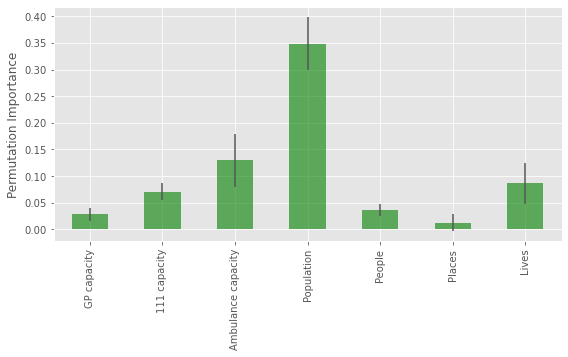

In [81]:
fig,ax = plt.subplots(figsize=(8,5))

importances[importances.columns[1:]].describe().loc['mean'].plot(kind='bar', \
            yerr = importances[importances.columns[1:]].describe().loc['std'],\
                            alpha=0.6, color='g',ax=ax)

plt.ylabel('Permutation Importance', fontsize=12)
plt.tight_layout()

tick_labels = ['GP capacity','111 capacity', 'Ambulance capacity',\
               'Population', 'People', 'Places', 'Lives']

ax.set_xticklabels(tick_labels)

plt.savefig('importance.png')
plt.show()

## Train final model on all data and save for forecasting 

In [83]:
def fit_final(dta, rf1, rf2, m1_features, m2_features):
    
    
    final = LinearRegression()


    #train capactiy model
    
    rf1 = fit_capacity(dta, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(dta[m1_features])

    
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    rf2.fit(X, y)
    
    y_pred_2 = rf2.predict(dta[m2_features])
        
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = dta['ae_attendances_attendances']

    final.fit(X_f,y_f)

    print('Combined training score:',final.score(X_f,y_f))
    
    return rf1,rf2, final        

In [84]:
m1_features = capacity_features
m2_features = pophealth_features

rf1,rf2,final = fit_final(dta, rf1, rf2, m1_features, m2_features)

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

Combined training score: 0.8014005341273812


/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped = grouped.append(ccg_year, ignore_index=True)
/var/folders/tw/p_xqdvms6gl3ng9h9q8vbw_m0000gq/T/ipykernel_93513/2337203325.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

In [85]:
with open('stacked_model_scaled.pkl','wb') as f:
    
    pkl.dump([[rf1,rf2,final], m1_features, m2_features], f)

In [86]:
dta.describe()

,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,rand1,ae_predicted
count,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000
mean,355.900356,307.688862,468.661503,350.400957,4362.920097,495.924693,61.015288,98.773208,99.655277,100.270029,0.498801,505.320050
std,178.265005,154.690514,367.818984,287.170269,782.803444,286.988469,47.762160,5.821863,2.441531,5.787486,0.294567,252.162939
min,18.364088,17.885025,168.908128,110.128890,1299.605358,101.447679,11.615900,84.800000,92.500000,87.400000,0.000546,279.255585
25%,272.220364,240.868701,225.764841,154.094309,3898.012359,296.700447,26.467100,94.300000,98.000000,96.500000,0.248753,324.314864
50%,330.942525,274.671104,269.156617,214.654611,4375.794700,383.551018,49.238700,98.850000,99.500000,99.500000,0.489459,446.868089
75%,373.169855,323.605872,674.555437,460.430391,4844.465810,606.213180,76.170300,103.657143,101.400000,105.205556,0.754901,515.867172
max,1372.703491,1225.432916,1698.974593,1377.465562,6937.180617,1460.369210,210.807400,111.200000,105.200000,113.300000,0.999809,1362.970411
